# skFIBERS Datasim Experiments

## Imports

In [1]:
import random
import numpy as np
import pandas as pd
from skfibers.fibers import FIBERS

In [2]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from skfibers.methods.fibers_methods import top_bin_summary_fibers

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'

## Functions to Generate Dataset

In [4]:
def generate_features(row, number_of_features, number_of_features_in_bin, mm_frequency_range):
    mm_frequency = np.random.uniform(mm_frequency_range[0], mm_frequency_range[1])
    if row['TrueRiskGroup'] == 1:
        idxs = random.sample(list(range(1, number_of_features_in_bin + 1)), 
                             int(mm_frequency * number_of_features_in_bin))
        for idx in idxs:
            row['P_' + str(idx)] = 1
        idxs = random.sample(list(range(1, number_of_features - number_of_features_in_bin + 1)), 
                             int(mm_frequency * (number_of_features - number_of_features_in_bin)))
        for idx in idxs:
            row['R_' + str(idx)] = 1
    else:
        idxs = random.sample(list(range(1, number_of_features - number_of_features_in_bin + 1)), 
                             int(mm_frequency * (number_of_features - number_of_features_in_bin)))
        for idx in idxs:
            row['R_' + str(idx)] = 1
    return row

In [5]:
def censor(df, censoring_frequency):
#     df['Censoring'] = df['TrueRiskGroup']
    df['Censoring'] = 1
    inst_to_censor = int(censoring_frequency * len(df)) # len(df[df['TrueRiskGroup']==1]))
    max_duration = max(df['Duration'])
    df = df.sort_values('Duration')
    censor_count = 0
    while censor_count < inst_to_censor:
        for index in range(len(df)):
            prob = df['Duration'].iloc[index]/max_duration
            choice = np.random.choice([0, 1], 1, p=[prob, 1-prob])
            if choice == 0:
                censor_count +=1
                df['Censoring'].iloc[index] = choice
            if censor_count >= inst_to_censor:
                break
    return df

In [6]:
def create_data_simulation_bin(number_of_instances, number_of_features, number_of_features_in_bin,
                               no_fail_proportion, mm_frequency_range, noise_frequency,
                               class0_time_to_event_range, class1_time_to_event_range, censoring_frequency):
    """
    Defining a function to create an artificial dataset with parameters, there will be one ideal/strong bin
    Note: MAF (minor allele frequency) cutoff refers to the threshold
    separating rare variant features from common features

    :param number_of_instances: dataset size
    :param number_of_features: total number of features in dataset
    :param number_of_features_in_bin: total number of predictive features in the ideal bin
    :param no_fail_proportion: the proportion of instances to be labled as (no fail class)
    :param mm_frequency_range: the max and min MM frequency for a given column/feature in data. (e.g. 0.1 to 0.5)
    :param noise_frequency: Value from 0 to 0.5 representing the proportion of class 0/class 1 instance pairs that \
                            have their outcome switched from 0 to 1
    :param class0_time_to_event_range: (min, max) time to event as a tuple (should be larger (e.g. 100 to 200)
    :param class1_time_to_event_range: (min, max) time to event as a tuple (should be smaller but a but overlapping \
                                        with above range (e.g. 20 to 150)

    :return: pandas dataframe of generated data
    """
    
    # Creating an empty dataframe to use as a starting point for the eventual feature matrix
    # Adding one to number of features to give space for the class and Duration column
    df = pd.DataFrame(np.zeros((number_of_instances, number_of_features + 2)))
    
    # Creating a list of predictive features in the strong bin
    predictive_features = ["P_" + str(i + 1) for i in range(number_of_features_in_bin)]

    # Creating a list of randomly created features
    random_features = ["R_" + str(i + 1) for i in range(number_of_features - number_of_features_in_bin)]

    # Adding the features and the class/endpoint
    df.columns  = predictive_features + random_features + ['TrueRiskGroup', 'Duration']
    
    # Assigning class according to no_fail_proportion parameter
    fail_count = int(number_of_instances * (1 - no_fail_proportion))
    no_fail_count = number_of_instances - fail_count
    class_list = [1] * fail_count + [0] * no_fail_count
    df['TrueRiskGroup'] = class_list
    
    # Generating predictive and random features columns
#     mm_frequency = np.random.uniform(mm_frequency_range[0], mm_frequency_range[1])
    df = df.apply(generate_features, 
                  args=(number_of_features, number_of_features_in_bin, 
                        mm_frequency_range), axis=1).astype(int)
    
    # Assigning Guassians according to class
    df_0 = df[df['TrueRiskGroup'] == 0].sample(frac=1).reset_index(drop=True)
    df_1 = df[df['TrueRiskGroup'] == 1].sample(frac=1).reset_index(drop=True)
    df_0['Duration'] = np.clip(np.random.normal(class0_time_to_event_range[0], 
                                         class0_time_to_event_range[1], size=len(df_0)), 
                               a_min = 0, a_max=None)
    df_1['Duration'] = np.clip(np.random.normal(class1_time_to_event_range[0], 
                                         class1_time_to_event_range[1], size=len(df_1)), 
                               a_min = 0, a_max=None)
    df = censor(pd.concat([df_0, df_1]), censoring_frequency)
    
    df_0 = df[df['Censoring'] == 0].sample(frac=1).reset_index(drop=True)
    df_1 = df[df['Censoring'] == 1].sample(frac=1).reset_index(drop=True)
    if noise_frequency > 0:
        swap_count = int(min(len(df_0), len(df_1)) * noise_frequency)
        idxs = random.sample(list(range(min(len(df_0), len(df_1)))), swap_count)
        for i in idxs:
            df_0['Censoring'].iloc[i], df_1['Censoring'].iloc[i] = \
            df_1['Censoring'].iloc[i].copy(), df_0['Censoring'].iloc[i].copy()
            df_0['Duration'].iloc[i], df_1['Duration'].iloc[i] = \
            df_1['Duration'].iloc[i].copy(), df_0['Duration'].iloc[i].copy()
    
    df = pd.concat([df_0, df_1]).sample(frac=1).reset_index(drop=True)
    return df

In [7]:
def create_negative_control(number_of_instances, number_of_features, number_of_features_in_bin,
                               no_fail_proportion, mm_frequency_range, noise_frequency,
                               class0_time_to_event_range, class1_time_to_event_range, censoring_frequency):
    """
    Defining a function to create an artificial dataset with parameters, there will be one ideal/strong bin
    Note: MAF (minor allele frequency) cutoff refers to the threshold
    separating rare variant features from common features

    :param number_of_instances: dataset size
    :param number_of_features: total number of features in dataset
    :param number_of_features_in_bin: total number of predictive features in the ideal bin
    :param no_fail_proportion: the proportion of instances to be labled as (no fail class)
    :param mm_frequency_range: the max and min MM frequency for a given column/feature in data. (e.g. 0.1 to 0.5)
    :param noise_frequency: Value from 0 to 0.5 representing the proportion of class 0/class 1 instance pairs that \
                            have their outcome switched from 0 to 1
    :param class0_time_to_event_range: (min, max) time to event as a tuple (should be larger (e.g. 100 to 200)
    :param class1_time_to_event_range: (min, max) time to event as a tuple (should be smaller but a but overlapping \
                                        with above range (e.g. 20 to 150)

    :return: pandas dataframe of generated data
    """
    
    # Creating an empty dataframe to use as a starting point for the eventual feature matrix
    # Adding one to number of features to give space for the class and Duration column
    df = pd.DataFrame(np.zeros((number_of_instances, number_of_features + 2)))
    
    # Creating a list of predictive features in the strong bin
    predictive_features = ["P_" + str(i + 1) for i in range(number_of_features_in_bin)]

    # Creating a list of randomly created features
    random_features = ["R_" + str(i + 1) for i in range(number_of_features - number_of_features_in_bin)]

    # Adding the features and the class/endpoint
    df.columns  = predictive_features + random_features + ['TrueRiskGroup', 'Duration']
    
    # Assigning class according to no_fail_proportion parameter
    fail_count = int(number_of_instances * (1 - no_fail_proportion))
    no_fail_count = number_of_instances - fail_count
    class_list = [1] * fail_count + [0] * no_fail_count
    df['TrueRiskGroup'] = class_list
    
    # Generating predictive and random features columns
#     mm_frequency = np.random.uniform(mm_frequency_range[0], mm_frequency_range[1])
    df = df.apply(generate_features, 
                  args=(number_of_features, number_of_features_in_bin, 
                        mm_frequency_range), axis=1).astype(int)
    
    # Assigning Guassians according to class
    df_0 = df[df['TrueRiskGroup'] == 0].sample(frac=1).reset_index(drop=True)
    df_1 = df[df['TrueRiskGroup'] == 1].sample(frac=1).reset_index(drop=True)
    df_0['Duration'] = np.clip(np.random.normal(class0_time_to_event_range[0], 
                                         class0_time_to_event_range[1], size=len(df_0)), 
                               a_min = 0, a_max=None)
    df_1['Duration'] = np.clip(np.random.normal(class1_time_to_event_range[0], 
                                         class1_time_to_event_range[1], size=len(df_1)), 
                               a_min = 0, a_max=None)
    df = censor(pd.concat([df_0, df_1]), censoring_frequency)
    
    df_0 = df[df['Censoring'] == 0].sample(frac=1).reset_index(drop=True)
    df_1 = df[df['Censoring'] == 1].sample(frac=1).reset_index(drop=True)
    if noise_frequency > 0:
        swap_count = int(min(no_fail_count, fail_count) * noise_frequency)
        idxs = random.sample(list(range(min(no_fail_count, fail_count))), swap_count)
        for i in idxs:
            df_0['Censoring'].iloc[i], df_1['Censoring'].iloc[i] = \
            df_1['Censoring'].iloc[i].copy(), df_0['Censoring'].iloc[i].copy()
            df_0['Duration'].iloc[i], df_1['Duration'].iloc[i] = \
            df_1['Duration'].iloc[i].copy(), df_0['Duration'].iloc[i].copy()
    
    df = pd.concat([df_0, df_1]).sample(frac=1).reset_index(drop=True)
    return df

In [8]:
data = create_data_simulation_bin(number_of_instances=10000, number_of_features=50, number_of_features_in_bin=10,
               no_fail_proportion=0.8, mm_frequency_range=(0.2, 0.9) , noise_frequency=0,
               class0_time_to_event_range=(0.7, 0.2), class1_time_to_event_range=(1.7, 0.2),
               censoring_frequency=0.5)

In [9]:
data.head(15)

,P_1,P_2,P_3,P_4,P_5,P_6,P_7,P_8,P_9,P_10,...,R_34,R_35,R_36,R_37,R_38,R_39,R_40,TrueRiskGroup,Duration,Censoring
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0.514993,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0.559394,1
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,0,1,0,0.501732,1
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,0,0.775732,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0.451551,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0.554771,1
6,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,0,0.496365,1
7,1,0,1,0,0,0,0,1,1,0,...,0,0,1,0,0,1,1,1,2.176711,0
8,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,0,0,0,0.498949,1
9,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,1,0,0.533208,0


## Functions to Run Experiment

In [10]:
def experiment(number_of_instances=10000, number_of_features=50, number_of_features_in_bin=10,
               no_fail_proportion=0.8, mm_frequency_range=(0.2, 0.9) , noise_frequency=0,
               class0_time_to_event_range=(1.5, 0.2), class1_time_to_event_range=(1, 0.2),
               censoring_frequency=0.5, exp_str='1'):
    for replicate in range(0, 1):
        print('Experiment ' + exp_str)
        # Creating the simulated dataset with 1000 instances, 10 features to bin, 50 total features
        # no_fail_proportion=0.5, mm_frequency_range=(0.1, 0.5) , noise_frequency=0,
        # class0_time_to_event_range=(100, 200), class1_time_to_event_range=(20, 150)
        data = create_data_simulation_bin(number_of_instances, number_of_features, number_of_features_in_bin,
                                          no_fail_proportion, mm_frequency_range , noise_frequency,
                                          class0_time_to_event_range, class1_time_to_event_range,
                                          censoring_frequency)
        data = data.drop('TrueRiskGroup', axis=1)
        fibers = FIBERS(given_starting_point=False, amino_acid_start_point=None, algorithm="FIBERS",
                        amino_acid_bins_start_point=None, iterations=100, label_name="Censoring",
                        duration_name="Duration", rare_variant_maf_cutoff=0.2,
                        set_number_of_bins=50, min_features_per_group=2,
                        max_number_of_groups_with_feature=2,
                        scoring_method='Relief',
                        score_based_on_sample=True, score_with_common_variables=False,
                        instance_sample_size=50, crossover_probability=0.8,
                        mutation_probability=0.4, elitism_parameter=0.8,
                        random_seed=None, bin_size_variability_constraint=None)
        fibers.fit(data)
        fibers, bin_feature_matrix_internal, amino_acid_bins_internal, \
            amino_acid_bin_scores_internal, maf_0_features = fibers.transform(data)
        sorted_bin_scores = dict(sorted(amino_acid_bin_scores_internal.items(), key=lambda item: item[1], reverse=True))
        sorted_bin_list = list(sorted_bin_scores.keys())
        sorted_bin_feature_importance_values = list(sorted_bin_scores.values())
        Bin = amino_acid_bins_internal[sorted_bin_list[0]]
        print("Best Bin:", Bin)
    return bin_feature_matrix_internal, amino_acid_bins_internal, \
        amino_acid_bin_scores_internal, maf_0_features

## Functions to plot outputs

In [11]:
def top_bin_summary_edited(original_feature_matrix, label_name, duration_name, bin_feature_matrix, bins, bin_scores):
    
    #Ordering the bin scores from best to worst
    sorted_bin_scores = dict(sorted(bin_scores.items(), key=lambda item: item[1], reverse=True))
    sorted_bin_list = list(sorted_bin_scores.keys())
    sorted_bin_feature_importance_values = list(sorted_bin_scores.values())
    
    topbin = sorted_bin_list[0]
    
    df_0 = bin_feature_matrix.loc[bin_feature_matrix[topbin] == 0]
    df_1 = bin_feature_matrix.loc[bin_feature_matrix[topbin] > 0]
        
    durations_no = df_0[duration_name].to_list()        
    event_observed_no = df_0[label_name].to_list()
    durations_mm = df_1[duration_name].to_list()
    event_observed_mm = df_1[label_name].to_list()
        
    results = logrank_test(durations_no, durations_mm, event_observed_A=event_observed_no, event_observed_B=event_observed_mm)
    
    print("Bin of Amino Acid Positions:")
    print(bins[topbin])
    print("---")
    print("Number of Instances with No Mismatches in Bin:")
    print(len(durations_no))
    print("Number of Instances with Mismatch(es) in Bin:")
    print(len(durations_mm))
    print("---")
    print("p-value from Log Rank Test:")
    print(results.p_value)
    results.print_summary()
    kmf1 = KaplanMeierFitter() 

    ## fit the model for 1st cohort
    kmf1.fit(durations_no, event_observed_no, label='No Mismatches in Bin')
    a1 = kmf1.plot()
    a1.set_ylabel('Survival Probability')

    ## fit the model for 2nd cohort
    kmf1.fit(durations_mm, event_observed_mm, label='Mismatch(es) in Bin')
    kmf1.plot(ax=a1)
    a1.set_xlabel('Years After Transplant')
    plt.show()

In [12]:
def score_df(amino_acid_bin_scores_internal, amino_acid_bins_internal):
    amino_acid_bin_scores_internal_sorted = sorted(amino_acid_bin_scores_internal.items(), 
                                                   key=lambda x:x[1], reverse=True)
    amino_acid_bins_internal_sorted = sorted(amino_acid_bins_internal.items(), 
                                             key=lambda x:len(x[1]), reverse=True)
    tdf1 = pd.DataFrame(amino_acid_bin_scores_internal_sorted, columns=['Bin #', 'Score'])
    tdf2 = pd.DataFrame(amino_acid_bins_internal_sorted, columns=['Bin #', 'Bins'])
    tdf3 = tdf1.merge(tdf2, on='Bin #', how='inner', suffixes=('_1', '_2'))
    display(tdf3.head(10).T)

## Testing Functions

In [13]:
bin_feature_matrix, amino_acid_bins, \
            amino_acid_bin_scores, maf_0_features = experiment(
                number_of_instances=10000, number_of_features=50, number_of_features_in_bin=10,
                no_fail_proportion=0.5, mm_frequency_range=(0.3, 0.4) , noise_frequency=0,
                class0_time_to_event_range=(1.5, 0.2), class1_time_to_event_range=(1, 0.2),
                censoring_frequency=0.5)

Experiment 1
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]


Best Bin: ['P_3', 'P_4', 'P_9', 'P_8', 'P_1']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 30,Bin 32,Bin 28,Bin 3,Bin 31,Bin 34,Bin 21,Bin 37,Bin 9,Bin 11
Score,4272.027579,4036.720159,3934.666049,3888.237908,3818.504739,3739.771006,3204.194374,3130.02371,3113.453683,3094.535547
Bins,"[P_3, P_4, P_9, P_8, P_1]","[P_7, P_9, P_4, P_8]","[P_9, P_8, P_5, P_10]","[P_2, P_9, P_8, P_4]","[P_2, P_4, P_6, P_1]","[P_4, P_6, P_9, P_8]","[P_7, P_5, P_8]","[P_6, P_2, P_4]","[P_6, P_2, P_10]","[P_9, P_8, P_4]"


Bin of Amino Acid Positions:
['P_3', 'P_4', 'P_9', 'P_8', 'P_1']
---
Number of Instances with No Mismatches in Bin:
5422
Number of Instances with Mismatch(es) in Bin:
4578
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        4272.03 <0.005       inf

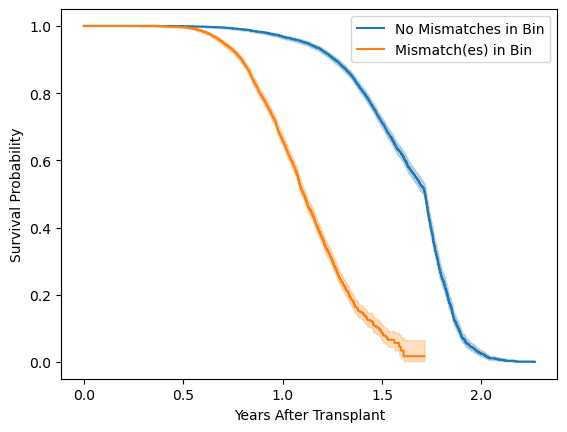

In [14]:
score_df(amino_acid_bin_scores, amino_acid_bins)
top_bin_summary_edited(pd.DataFrame(), "Censoring", "Duration", bin_feature_matrix, amino_acid_bins,
                           amino_acid_bin_scores)

Experiment MM Freq Range=(0.1, 0.3), Censoring Freq=0.1
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


Best Bin: ['P_3', 'P_4', 'R_6', 'P_6', 'P_7', 'P_8']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 20,Bin 30,Bin 16,Bin 33,Bin 8,Bin 35,Bin 34,Bin 37,Bin 36,Bin 18
Score,222.211868,215.250537,164.061434,137.944529,134.999498,132.266824,130.180049,126.895277,122.916129,114.686057
Bins,"[P_3, P_4, R_6, P_6, P_7, P_8]","[R_13, P_2, P_4, P_7, P_1, P_10]","[P_2, P_4, P_6, R_33, P_5]","[P_6, P_4, R_12, P_2, P_5]","[P_6, P_8, P_5, R_20, P_1, P_10, P_3, R_26]","[P_1, P_2, P_5, R_13, P_6]","[P_3, R_15, P_7, P_1]","[P_3, R_29, P_7, P_4, P_1]","[P_4, P_7, P_1, R_1]","[P_3, P_6, P_5, R_10]"


Bin of Amino Acid Positions:
['P_3', 'P_4', 'R_6', 'P_6', 'P_7', 'P_8']
---
Number of Instances with No Mismatches in Bin:
7135
Number of Instances with Mismatch(es) in Bin:
2865
---
p-value from Log Rank Test:
2.9780333510124516e-50


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         222.21 <0.005    164.52

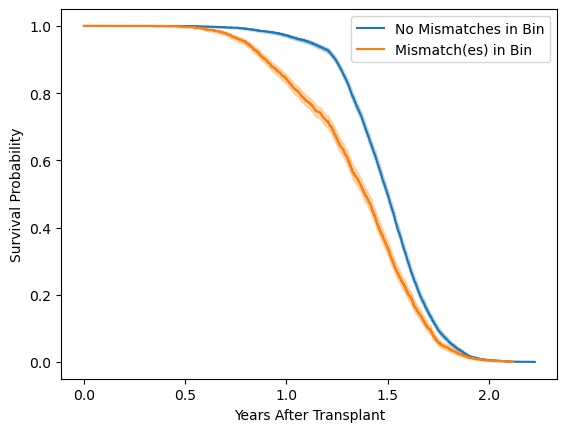

Experiment MM Freq Range=(0.1, 0.3), Censoring Freq=0.3
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:24<00:00,  1.19it/s]


Best Bin: ['R_37', 'P_3', 'P_2', 'P_8', 'P_7']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 12,Bin 11,Bin 24,Bin 14,Bin 8,Bin 20,Bin 9,Bin 22,Bin 26,Bin 7
Score,147.678736,143.125978,142.678922,109.85204,109.612317,108.881999,101.778995,95.76341,95.511567,86.274717
Bins,"[R_37, P_3, P_2, P_8, P_7]","[R_33, P_8, P_1, P_6]","[R_32, P_2, P_4, P_1, P_6]","[P_2, P_4, P_8, R_4]","[R_19, P_2, P_8, P_1, P_10]","[P_3, P_2, P_4, R_6, P_7, P_6, P_1, R_13, R_26]","[P_8, R_9, P_4, P_5]","[P_3, P_2, P_4, P_8, R_17, R_12, P_7]","[P_6, P_8, P_1, R_1]","[P_10, P_2, P_9, R_4, R_7, P_5]"


Bin of Amino Acid Positions:
['R_37', 'P_3', 'P_2', 'P_8', 'P_7']
---
Number of Instances with No Mismatches in Bin:
7333
Number of Instances with Mismatch(es) in Bin:
2667
---
p-value from Log Rank Test:
5.57645728604635e-34


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         147.68 <0.005    110.47

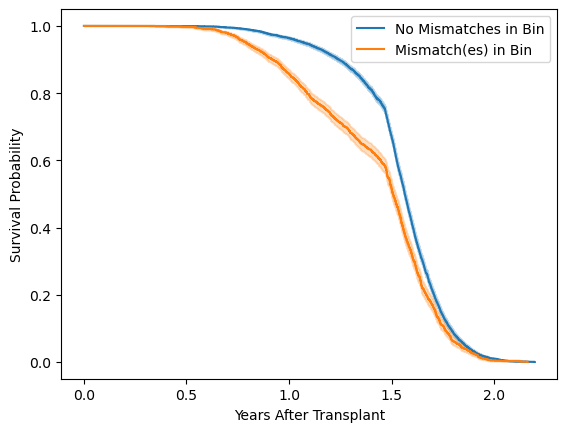

Experiment MM Freq Range=(0.1, 0.3), Censoring Freq=0.5
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:23<00:00,  1.19it/s]


Best Bin: ['P_3', 'P_6', 'P_4', 'P_10', 'R_12']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 38,Bin 40,Bin 22,Bin 32,Bin 9,Bin 29,Bin 28,Bin 25,Bin 12,Bin 21
Score,181.772692,142.837473,138.578756,125.501889,124.055353,123.999999,123.579638,123.215537,121.05731,118.207474
Bins,"[P_3, P_6, P_4, P_10, R_12]","[P_3, P_1, P_6, R_15, R_15]","[P_3, P_2, P_4, P_5, R_20, R_30]","[R_18, P_2, P_6, P_9]","[P_6, P_10, P_2, P_3, R_16, R_10]","[R_13, P_3, P_4, P_7]","[P_3, R_10, P_6]","[P_2, P_6, P_9, R_24]","[P_3, P_4, R_24, P_9]","[P_3, P_8, P_2, R_9]"


Bin of Amino Acid Positions:
['P_3', 'P_6', 'P_4', 'P_10', 'R_12']
---
Number of Instances with No Mismatches in Bin:
7246
Number of Instances with Mismatch(es) in Bin:
2754
---
p-value from Log Rank Test:
1.9878337383299308e-41


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         181.77 <0.005    135.21

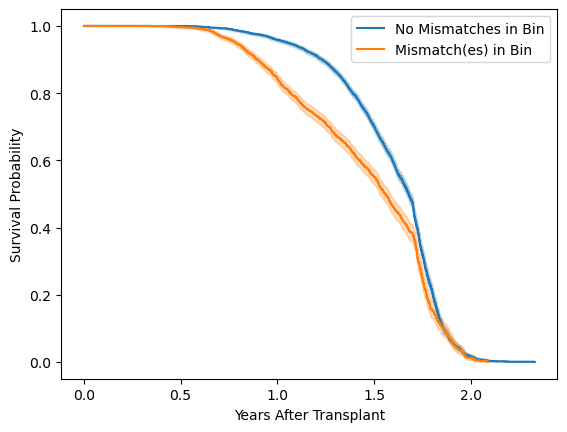

Experiment MM Freq Range=(0.1, 0.3), Censoring Freq=0.7
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


Best Bin: ['P_4', 'P_6', 'P_7', 'R_34', 'P_5', 'P_2']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 27,Bin 13,Bin 26,Bin 40,Bin 38,Bin 29,Bin 37,Bin 11,Bin 6,Bin 8
Score,204.655309,164.535259,156.919958,148.884838,127.633316,112.926399,111.986388,109.192523,105.777526,102.451535
Bins,"[P_4, P_6, P_7, R_34, P_5, P_2]","[P_7, P_9, P_6, P_5, R_38]","[P_10, P_6, P_1, P_5, R_29]","[P_9, P_8, P_5, P_10, R_12]","[P_8, P_10, R_3, P_4, P_1]","[P_2, P_6, P_9, P_7, R_38, R_6, P_3]","[P_7, P_9, P_2, R_6]","[P_6, P_7, P_10, R_9, P_4]","[R_6, P_6, P_7, P_5]","[R_25, P_9, P_10, P_5]"


Bin of Amino Acid Positions:
['P_4', 'P_6', 'P_7', 'R_34', 'P_5', 'P_2']
---
Number of Instances with No Mismatches in Bin:
7164
Number of Instances with Mismatch(es) in Bin:
2836
---
p-value from Log Rank Test:
2.013706536219185e-46


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         204.66 <0.005    151.80

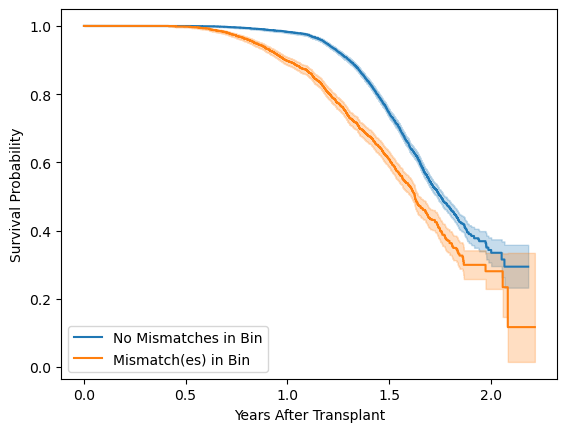

Experiment MM Freq Range=(0.1, 0.3), Censoring Freq=0.9
FIBERS


 59%|████████████████████████▊                 | 59/100 [00:49<00:34,  1.17it/s]

In [ ]:
for i in range(1, 7):
    for j in range(1, 10, 2):
        bin_feature_matrix, amino_acid_bins, \
                amino_acid_bin_scores, maf_0_features = experiment(
            mm_frequency_range=(i/10, (i+2)/10) , 
            censoring_frequency=j/10, 
            exp_str="MM Freq Range=" + str((i/10, (i+2)/10)) + ", Censoring Freq="+str(j/10)
        )
        score_df(amino_acid_bin_scores, amino_acid_bins)
        top_bin_summary_edited(pd.DataFrame(), "Censoring", "Duration", bin_feature_matrix, amino_acid_bins,
                               amino_acid_bin_scores)